In [1]:
import torch
import onnx
from onnx import numpy_helper
from onnx2torch import convert
import tqdm
import numpy as np
import gc

In [3]:
# !pip install onnx2torch

In [2]:
### load ds
from face_lib.dataset_classes.lightning_datasets import MXFaceDataset

vgg_ds = MXFaceDataset("/app/datasets/faces_vgg_112x112")
# softmax_weights_path = '/app/model_weights/softmax_weight.pt'
# softmax_weights = torch.load(softmax_weights_path)
# softmax_weights_norm = torch.norm(
#             softmax_weights, dim=1, keepdim=True
#         )  # [N, 512]
# softmax_weights = (
#             softmax_weights / softmax_weights_norm
#         )

/home/kolesnikov/miniconda/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [3]:
onnx_model = onnx.load("/app/model_weights/backbone/vgg_iresnet50/vgg2_r50.onnx")

In [4]:
torch_model = convert(onnx_model)

In [5]:
labels = np.load("/app/datasets/faces_vgg_112x112/labels.npy")

In [7]:
labels_tuple = np.unique(labels, return_counts = True)

In [11]:
print(labels_tuple[1][5])

259


In [12]:
torch_model.to("cuda:0")

GraphModule(
  (Conv_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (initializers): Module()
  (PRelu_1): OnnxPReLU()
  (BatchNormalization_2): BatchNorm2d(64, eps=9.999999747378752e-06, momentum=0.10000002384185791, affine=True, track_running_stats=True)
  (Conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (PRelu_4): OnnxPReLU()
  (Conv_5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (Conv_6): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
  (Add_7): OnnxBinaryMathOperation()
  (BatchNormalization_8): BatchNorm2d(64, eps=9.999999747378752e-06, momentum=0.10000002384185791, affine=True, track_running_stats=True)
  (Conv_9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (PRelu_10): OnnxPReLU()
  (Conv_11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Add_12): OnnxBinaryMathOperation()
  (BatchNormalization_13): BatchNorm2d(64, eps=9.999999747378752e-06, momentum=0.

Усреднение эмбедингов:

In [13]:
torch_model.eval()

GraphModule(
  (Conv_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (initializers): Module()
  (PRelu_1): OnnxPReLU()
  (BatchNormalization_2): BatchNorm2d(64, eps=9.999999747378752e-06, momentum=0.10000002384185791, affine=True, track_running_stats=True)
  (Conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (PRelu_4): OnnxPReLU()
  (Conv_5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (Conv_6): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
  (Add_7): OnnxBinaryMathOperation()
  (BatchNormalization_8): BatchNorm2d(64, eps=9.999999747378752e-06, momentum=0.10000002384185791, affine=True, track_running_stats=True)
  (Conv_9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (PRelu_10): OnnxPReLU()
  (Conv_11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Add_12): OnnxBinaryMathOperation()
  (BatchNormalization_13): BatchNorm2d(64, eps=9.999999747378752e-06, momentum=0.

In [14]:
sfw_vgg = []
current_ind = 0

In [15]:
for i in tqdm.tqdm(range(len(labels_tuple[0]))):
    with torch.no_grad():
        batch_for_label = torch.cat([vgg_ds[current_ind + j][0][None, ...] for j in range(labels_tuple[1][i])]).to("cuda:0")
        emb_batch = torch_model(batch_for_label)
        #print(emb_batch.shape)
        mean_emb = torch.mean(emb_batch, dim = 0)
    sfw_vgg.append(mean_emb.to("cpu"))
    current_ind += labels_tuple[1][i]
    torch.cuda.empty_cache()
    gc.collect()

100%|██████████| 8631/8631 [2:24:41<00:00,  1.01s/it]  


In [16]:
sfw_vgg_torch = torch.stack(sfw_vgg)

In [17]:
sfw_vgg_torch.shape

torch.Size([8631, 512])

In [19]:
torch.save(sfw_vgg_torch, "/app/model_weights/backbone/vgg_iresnet50/softmax_weights_mean_vgg.pt")

In [20]:
sfw_vgg_normalised = torch.nn.functional.normalize(sfw_vgg_torch, p=2.0, dim=1)

In [21]:
torch.save(sfw_vgg_normalised, "/app/model_weights/backbone/vgg_iresnet50/softmax_weights_mean_vgg_normalised.pt")

In [49]:
### load model
from face_lib.models.lightning_wrappers import ResNet

backbone_old = ResNet(
    "iresnet50_normalized",
    "/app/model_weights/backbone/ms1mv3_arcface_r50/backbone.pth",
    learnable=False,
)

/app/face_lib/models/lightning_wrappers.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  backbone_dict = torch.load(weights)


In [12]:
### predict emb
# x = vgg_ds[0][0][None, ...]
id = 0
x = torch.cat([vgg_ds[2000][0][None, ...], vgg_ds[1][0][None, ...]])
torch_model.to("cpu")
backbone_outputs = torch_model(x)
backbone_outputs = torch.nn.functional.normalize(backbone_outputs, p=2.0, dim = 1)
emb = backbone_outputs

In [24]:
vgg_ds[2000][1]

tensor(6)

In [13]:
sfw_vgg_normalised = torch.load("/app/model_weights/backbone/vgg_iresnet50/softmax_weights_mean_vgg_normalised.pt")

/tmp/ipykernel_852202/1228789056.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sfw_vgg_normalised = torch.load("/app/model_weights/backbone/vgg_iresnet50/softmax_weigh

In [14]:
import numpy as np

cos = []
for weight in sfw_vgg_normalised:
    cos.append(weight.detach().numpy() @ emb[0].detach().numpy())
cos = np.array(cos)

In [25]:
print(np.max(cos))

0.49048865


In [64]:
max(cos)

18.790724

In [58]:
np.max(cos)
np.min(cos)

-0.1538214

In [12]:
len(vgg_ds)

3137807

Saving Softmax Weights from model to separate file

In [6]:
model_trained = torch.load("/app/outputs/scf_new_data/arcface_vgg2_version2/epoch=24-step=153200.ckpt")

/tmp/ipykernel_911471/2239873982.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_trained = torch.load("/app/outputs/scf_new_data/arcface_vgg2_version2/epoch=24-ste

In [7]:
model_trained.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])

In [8]:
sw_trained = model_trained["state_dict"]["softmax_weights"]

In [9]:
torch.save(sw_trained, "/app/model_weights/backbone/vgg_iresnet50/softmax_weights_trained_correct.pt")

Testing new softmax weights

In [65]:
### predict emb
# x = vgg_ds[0][0][None, ...]
id = 0
x = torch.cat([vgg_ds[2000347][0][None, ...], vgg_ds[1][0][None, ...]])
torch_model.to("cpu")
backbone_new_outputs = torch_model(x)
backbone_new_outputs = torch.nn.functional.normalize(backbone_new_outputs, p=2.0, dim = 1)
backbone_old_outputs = backbone_old(x)

In [66]:
sw_trained = torch.nn.functional.normalize(sw_trained, p=2.0, dim = 1)

In [67]:
import numpy as np

cos_new = []
cos_old = []
for weight in sw_trained:
    cos_new.append(weight.detach().cpu().numpy() @ backbone_new_outputs[0].detach().cpu().numpy())
    cos_old.append(weight.detach().cpu().numpy() @ backbone_old_outputs["feature"][0].detach().cpu().numpy())
cos_new = np.array(cos_new)
cos_old = np.array(cos_old)

In [68]:
np.argmax(cos_new)

5460

In [69]:
np.max(cos_new)

0.38555342

In [59]:
print(np.argmax(cos_old))
print(np.max(cos_old))

2024
0.15234926


In [43]:
vgg_ds[200345][1]

tensor(543)

In [ ]:
for image in vgg_ds:
    pass

In [5]:
from torch.utils.data import DataLoader

In [5]:
dl = DataLoader(
            vgg_ds,
            batch_size=512,
            drop_last=False,
            shuffle=False,
            num_workers=40,
        )

In [4]:
torch_model = torch.load("/app/model_weights/backbone/vgg_iresnet50/backbone_vgg.pth")

/tmp/ipykernel_215118/2589918397.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_model = torch.load("/app/model_weights/backbone/vgg_iresnet50/backbone_vgg.pth")


In [7]:
torch_model.to("cuda:1")

GraphModule(
  (Conv_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (initializers): Module()
  (PRelu_1): OnnxPReLU()
  (BatchNormalization_2): BatchNorm2d(64, eps=9.999999747378752e-06, momentum=0.10000002384185791, affine=True, track_running_stats=True)
  (Conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (PRelu_4): OnnxPReLU()
  (Conv_5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (Conv_6): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
  (Add_7): OnnxBinaryMathOperation()
  (BatchNormalization_8): BatchNorm2d(64, eps=9.999999747378752e-06, momentum=0.10000002384185791, affine=True, track_running_stats=True)
  (Conv_9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (PRelu_10): OnnxPReLU()
  (Conv_11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Add_12): OnnxBinaryMathOperation()
  (BatchNormalization_13): BatchNorm2d(64, eps=9.999999747378752e-06, momentum=0.

In [8]:
res = []
for batch in tqdm.tqdm(dl):
    batch_cuda = batch[0].to("cuda:1")
    output = torch.nn.functional.normalize(torch_model(batch_cuda), p =2.0, dim = 1).detach().cpu().numpy()
    res.append(output)

100%|██████████| 6129/6129 [26:39<00:00,  3.83it/s]


In [9]:
import numpy as np

In [10]:
res = np.concatenate(res, axis = 0)
np.save("/app/model_weights/backbone/vgg_iresnet50/resnet50_embs.npy", res)

In [11]:
res.shape

(3137807, 512)

Смотрим распределение получившихся косинусных расстояний

In [10]:
from face_lib.models.scf import SoftmaxWeights

In [11]:
vgg_embs = np.load("/app/model_weights/backbone/vgg_iresnet50/resnet50_embs.npy")
labels = np.load("/app/datasets/faces_vgg_112x112/labels.npy")

In [12]:
vgg_embs.shape

(3137807, 512)

In [13]:
radius = 64
features = torch.tensor(vgg_embs, dtype=torch.float32)
softmax_weights = SoftmaxWeights(
    softmax_weights_path="/app/model_weights/backbone/vgg_iresnet50/softmax_weights_trained_correct.pt",
    radius=radius,
).softmax_weights.cpu()
wc = softmax_weights[labels, :]
cosine_sim = torch.sum(features * wc, dim=1, keepdim=True) / radius
cosine_sim = cosine_sim[:, 0].detach().cpu().numpy()
cosine_sim.shape

/app/face_lib/models/scf.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.softmax_weights = torch.load(softmax_weights_path)


(3137807,)

In [23]:
np.save("/app/model_weights/backbone/vgg_iresnet50/cosine_sim.npy", cosine_sim)

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
np.mean(cosine_sim)

0.31868228

Text(0.5, 9.444444444444438, 'Cosine Sim')

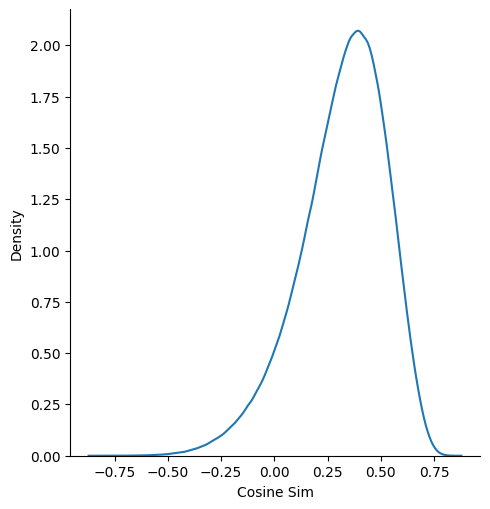

In [16]:
sns.displot(
    cosine_sim,
    kind="kde",
    # x="Cosine Sim",
    # hue="Error Kind",
    log_scale=False,
    common_norm=False,
)
plt.xlabel(f"Cosine Sim")
# plt.savefig(out_name, dpi=300)

/home/kolesnikov/miniconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

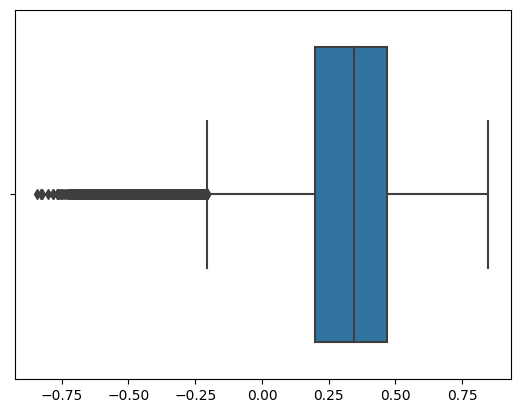

In [17]:
sns.boxplot(cosine_sim)

In [15]:
trained_arcface = torch.load("/app/outputs/scf_new_data/arcface_vgg2/epoch=19-step=122560.ckpt")

/tmp/ipykernel_215118/312262960.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_arcface = torch.load("/app/outputs/scf_new_data/arcface_vgg2/epoch=19-step=122560

In [19]:
softmax_weights = trained_arcface["state_dict"]["softmax_weights"].detach().cpu()

In [20]:
torch.norm(softmax_weights)

tensor(2031.8553)

In [21]:
softmax_weights = torch.nn.functional.normalize(softmax_weights, p=2.0, dim = 1)

Проверим, совпадает ли максимум логитов с нужным косинусным расстоянием до лейбла

In [18]:
softmax_weights.shape

torch.Size([8631, 512])

In [19]:
vgg_embs.shape

(3137807, 512)

In [22]:
logits = torch.nn.functional.linear(torch.tensor(vgg_embs[,:]), softmax_weights) / 64
logits.shape

torch.Size([8631])

In [23]:
logits_np = logits.detach().cpu().numpy()

In [26]:
np.argmax(logits_np) == vgg_ds[20300][1]

tensor(False)

In [25]:
np.max(logits_np)

0.54376686

In [20]:
wrong_counter = 0
for i in range(100000):
    logits = torch.nn.functional.linear(torch.tensor(vgg_embs[i,:]), softmax_weights) / 64
    logits_np = logits.detach().cpu().numpy()
    if np.argmax(logits_np) != vgg_ds[20300][1]:
        wrong_counter += 1
        print(np.max(logits_np))

0.3946598
0.38153434
0.42171717
0.35947388
0.4746565
0.20225514
0.37428486
0.4509384
0.51012534
0.38908052
0.20471069
0.5271518
0.58554226
0.49960014
0.24600327
0.440794
0.28254133
0.23927213
0.36087406
0.48664665
0.6392559
0.24492104
0.42983538
0.22216278
0.25965053
0.2667076
0.18892425
0.26718807
0.38611382
0.54555994
0.40011066
0.2326509
0.22677997
0.5024229
0.2504119
0.23036054
0.22507578
0.253317
0.23922178
0.29465294
0.22829774
0.3342429
0.40995407
0.2590793
0.20611024
0.40534383
0.27573797
0.39530993
0.33369058
0.42593393
0.40905333
0.32059708
0.24228096
0.21198337
0.21474819
0.2664019
0.3951599
0.25126994
0.35912782
0.67998874
0.25945407
0.40518928
0.20462798
0.27471316
0.2453225
0.5830889
0.2889234
0.5076368
0.3223722
0.46534163
0.54986024
0.41588342
0.20395719
0.260207
0.24165672
0.27776313
0.39604172
0.32906556
0.49386048
0.2461829
0.5203837
0.23775941
0.50368315
0.2855835
0.26946777
0.25321895
0.536693
0.5526236
0.27461433
0.29264325
0.43202332
0.44384572
0.35710007
0.20394

In [21]:
wrong_counter

99876